# C-mean Clustering
Fuzzy c-Means Clustering} (FMC) is a clustering method which, unlike Hard k-Means Clustering, allows a data sample to more or less belong to one or more clusters. In this notebook, we will try to develop a semi-supervised C-mean Clustering.

## Loading the packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import random
import operator
import math
colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

PATH_TO_DATASET = '' # Not Given Yet 

%matplotlib inline

## The dataset
The following script allows you to create a 2D dataset by using the mouse. The fift first click adds points belonging to class A (blue), the 5th following click adds points belonging to class B (red) and the next click add unclassified points. You can create as many points as you desire. The final dataset will contain hence three values per point: x coordinate (-1 ≤ x ≤ 1), y coordinate (-1 ≤ y ≤ 1) and the class ∈ {0,1,2} where 0 represent unclassified points.

In [2]:
%matplotlib notebook

fig = plt.figure(figsize=(6,6))
plt.title("Input Dataset")
plt.xlim((-1.2,1.2))
plt.ylim((-1.2,1.2))

dataset = []

i = 0
def onclick(event):
    global dataset
    global i
    cx = event.xdata
    cy = event.ydata
    classe = 1 if(i<10) else 2 if(i<20) else 0
    i=i+1
    dataset.append((cx, cy, classe))

    plt.scatter(cx, cy, c=['k', 'b', 'r'][classe], s=100, lw=0)
    plt.grid(True)

cid = fig.canvas.mpl_connect('button_press_event', onclick)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


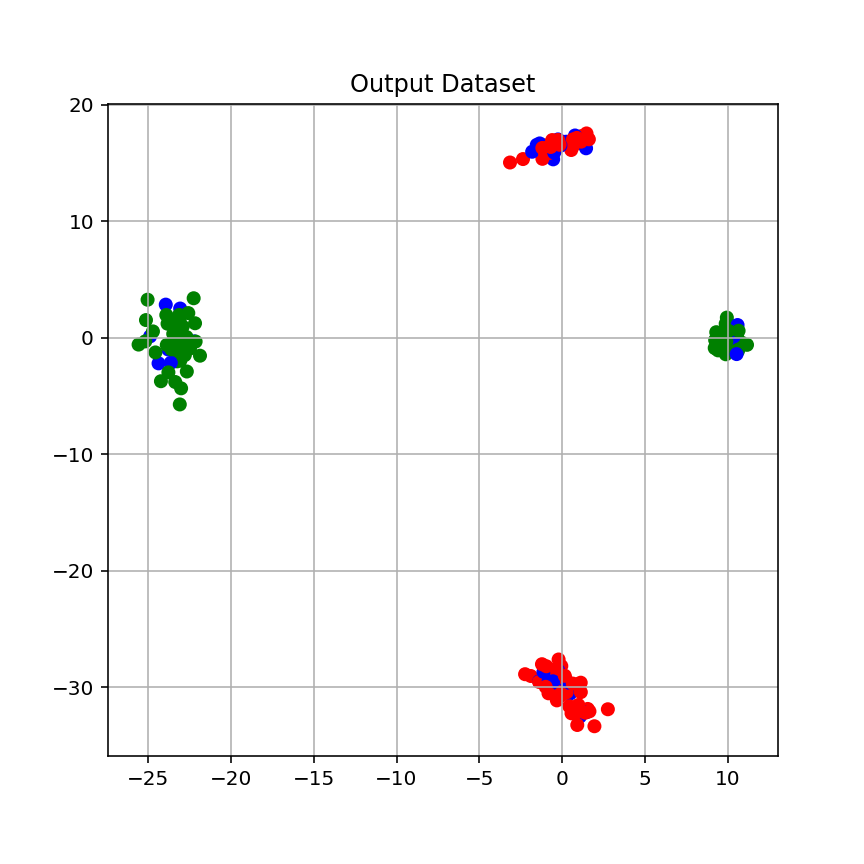

[[ 1.06262015e+01 -1.12655927e+00]
 [ 9.87665154e+00  1.19002309e+00]
 [ 9.42308550e+00 -1.72419995e-01]
 [ 9.21363768e+00 -8.94938835e-01]
 [ 9.66481655e+00 -2.18257613e-01]
 [ 1.05551001e+01  4.23975973e-01]
 [ 9.88656725e+00 -1.43541517e+00]
 [ 1.01752144e+01  3.46956492e-01]
 [ 1.04399174e+01  6.61523606e-01]
 [ 1.03997106e+01  2.24094256e-01]
 [ 1.00513142e+01 -2.93055392e-01]
 [ 9.84495548e+00  5.58104423e-01]
 [ 1.02526919e+01 -1.41999001e-01]
 [ 9.91215761e+00  1.51431749e-01]
 [ 9.92859463e+00  7.25965298e-01]
 [ 9.42837709e+00 -2.39016434e-01]
 [ 9.24095904e+00 -2.18140449e-01]
 [ 1.04347029e+01 -5.27445367e-01]
 [ 1.00724897e+01 -5.87579188e-01]
 [ 1.05684319e+01  4.33928242e-02]
 [ 1.08386490e+01 -4.36298705e-01]
 [ 9.76745199e+00 -7.71070564e-01]
 [ 1.02459732e+01  9.19437034e-01]
 [ 9.94621769e+00  1.71371638e+00]
 [ 1.03634570e+01  9.69616849e-01]
 [ 1.02227019e+01 -2.10591663e-01]
 [ 9.68698286e+00 -4.78871507e-01]
 [ 9.97890477e+00  3.83714525e-02]
 [ 1.02255540e+01  9

In [15]:
import numpy as np

def random_positive_semidefinite_matrix(d):
    Q = np.random.randn(d, d)
    eigvals = np.random.rand(d)
    return Q.T @ np.diag(eigvals) @ Q
    
    while True:
        A = np.random.rand(d, d)
        A += A.T
        if np.all(np.linalg.eigvals(A) > 0):
            return A

def make_spiral_clusters(c, cluster_size, n_noise, d=2):
    angle = np.linspace(0, 2*np.pi, c, endpoint=False)
    radius = np.linspace(10, 30, c)
    vx = np.cos(angle)*radius
    vy = np.sin(angle)*radius
    v = np.stack([vx, vy], axis=1)

    covariances = np.array([random_positive_semidefinite_matrix(d) for _ in range(c)])

    x = np.concatenate([np.random.multivariate_normal(v[i], covariances[i], cluster_size)
        for i in range(c)], axis=0)

    u = np.random.rand(n_noise, d)
    noise = np.min(x, axis=0)*u + (1 - u)*np.max(x, axis=0)

    x = np.concatenate([x, noise], axis=0)

    return x, v


dataset, true_centers = make_spiral_clusters(4, 50, 0)

labels = [1]*int(len(dataset)/4) + [2]*int(len(dataset)/4) + [1]*int(len(dataset)/4) + [2]*int(len(dataset)/4)
for i in range(50):
    labels[np.random.randint(len(labels))] = 0

fig2 = plt.figure(figsize=(6,6))
plt.title("Output Dataset")

plt.scatter(dataset[:,0], dataset[:,1], c=[(['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'])[int(label)] for label in labels])
plt.grid()
plt.show()
print(dataset)

In [16]:
dataset = np.array(dataset)
labels = np.expand_dims(labels, axis=1)
dataset = np.append(dataset, labels, axis=1)
print(dataset)

[[ 1.06262015e+01 -1.12655927e+00  1.00000000e+00]
 [ 9.87665154e+00  1.19002309e+00  1.00000000e+00]
 [ 9.42308550e+00 -1.72419995e-01  1.00000000e+00]
 [ 9.21363768e+00 -8.94938835e-01  1.00000000e+00]
 [ 9.66481655e+00 -2.18257613e-01  1.00000000e+00]
 [ 1.05551001e+01  4.23975973e-01  0.00000000e+00]
 [ 9.88656725e+00 -1.43541517e+00  1.00000000e+00]
 [ 1.01752144e+01  3.46956492e-01  1.00000000e+00]
 [ 1.04399174e+01  6.61523606e-01  1.00000000e+00]
 [ 1.03997106e+01  2.24094256e-01  1.00000000e+00]
 [ 1.00513142e+01 -2.93055392e-01  1.00000000e+00]
 [ 9.84495548e+00  5.58104423e-01  1.00000000e+00]
 [ 1.02526919e+01 -1.41999001e-01  1.00000000e+00]
 [ 9.91215761e+00  1.51431749e-01  1.00000000e+00]
 [ 9.92859463e+00  7.25965298e-01  1.00000000e+00]
 [ 9.42837709e+00 -2.39016434e-01  1.00000000e+00]
 [ 9.24095904e+00 -2.18140449e-01  1.00000000e+00]
 [ 1.04347029e+01 -5.27445367e-01  1.00000000e+00]
 [ 1.00724897e+01 -5.87579188e-01  1.00000000e+00]
 [ 1.05684319e+01  4.33928242e-

## Membership Matrix
The Membership matrix lists all the data samples membership grades to a particular cluster. Here we first randomly initialize it.

In [5]:
def initializeMembershipMatrix(dataset, k):
    membership_mat = list()
    for i in range(len(dataset)):
        random_num_list = [random.random() for i in range(k)]
        summation = sum(random_num_list)
        temp_list = [x/summation for x in random_num_list]
        membership_mat.append(temp_list)
    return membership_mat

## Cluster Center
Here we calculate each cluster center depending on the membership grades.

In [6]:
def calculateClusterCenter(dataset, membership_mat, k, fuzzy_param):
    cluster_mem_val = list(zip(*membership_mat))
    cluster_centers = list()
    for j in range(k):
        x = cluster_mem_val[j]
        xraised = [e ** fuzzy_param for e in x]
        denominator = sum(xraised)
        temp_num = list()
        for i in range(len(dataset)):
            data_point = dataset[i]
            prod = [xraised[i] * val for val in data_point]
            temp_num.append(prod)
        numerator = map(sum, zip(*temp_num))
        center = [z/denominator for z in numerator]
        cluster_centers.append(center)
    return cluster_centers

## Semi-supervised C-Mean

In [7]:
def evalConvergence(mb, previous_mb, threshold):
    return (np.absolute(np.array(mb) - np.array(previous_mb))).max() < threshold
        

In [8]:
def initializeMembershipMatrixSupervised(dataset, k):
    membership_mat_supervised = list()
    for i in range(len(dataset)):
        if (dataset[i][2] == 0):
            random_num_list = [0 for i in range(k)]
        else:
            random_num_list = [1 if((i+1)==dataset[i][2]) else 0 for i in range(k)]
        
        membership_mat_supervised.append(random_num_list)
    return membership_mat_supervised

In [9]:
def evalAccuracy(dataset, k):
    pass

In [10]:
def calculateClusterCenterSup(dataset, membership_mat, membership_mat_sup,  k, fuzzy_param):
    cluster_centers = []
    for i in range(k):
        for n in range(len(dataset)):
            denum = abs(membership_mat[n][i] - membership_mat_sup[n][i]) ** fuzzy_param
            num = denum*dataset[n]#dataset[n, :-1] ? 
        cluster_centers.append(num/denum)
    return cluster_centers

In [11]:
def updateMembershipValueSup(dataset, membership_mat, membership_mat_sup, cluster_centers, fuzzy_param, k):
    def d(n, c):
        return np.linalg.norm(list(map(operator.sub, dataset[n], cluster_centers[c])))** 2
    p = 1/(fuzzy_param- 1)
    
    for i in range(k):
        for n in range(len(dataset)):  
            membership_mat[n][i] = membership_mat_sup[n][i] + (1 - np.sum(membership_mat_sup[n])) * d(n, i) ** p / np.sum([d(n,j) for j in range(k)])
    return membership_mat

In [22]:
import numpy as np
import scipy.spatial
import copy

def pairwise_squared_distances(A, B):
    return scipy.spatial.distance.cdist(A, B)**2

def calculate_covariances(x, u, v, m):
    c, n = np.array(u).shape
    d = np.array(v).shape[1]
    
    um = np.array(u)**m

    covariances = np.zeros((c, d, d))

    for i in range(c):
        xv = x - v[i]
        uxv = um[i, :, np.newaxis]*xv
        covariances[i] = np.einsum('ni,nj->ij', uxv, xv)/np.sum(um[i])
    
    return covariances

# Partition Coefficient
def pc(x, u, v, m):
    c, n = np.array(u).shape
    return np.square(np.array(u)).sum()/n

# Fuzzy Hyperbolic Volume
def fhv(x, u, v, m):
    covariances = calculate_covariances(x, u, v, m)
    return sum(np.sqrt(np.linalg.det(cov)) for cov in covariances)

# Xie-Beni Index
def xb(x, u, v, m):
    n = np.array(x).shape[0]
    c = np.array(v).shape[0]

    um = np.array(u)**m
    
    d2 = pairwise_squared_distances(x, v)
    v2 = pairwise_squared_distances(v, v)
    
    v2[v2 == 0.0] = np.inf

    return np.sum(um.T*d2)/(n*np.min(v2))

def checkKnownEntriesBetter(dataset, labels, c):
    res = np.zeros((c, 2))
    for cluster in range(c) :
        for i in range(len(dataset)):
            if(dataset[i][-1] != 0 and labels[i] == cluster):
                res[cluster][int(dataset[i][-1] - 1)] += 1
        
    print("res1", res)
    
    for cluster in range(c):
        c_total = res[cluster][0] + res[cluster][1]
        res[cluster][0] /= c_total
        res[cluster][1] /= c_total

    print("res2", res)
    return res
        
    

def checkKnownEntries(x, labels, c):
    
    # 4 columns for each cluster :
    # |# class0 |# class1 | %0 | %1 |
    min_c = min(labels)
    res = [[0 for i in range(4)] for j in range(c)]
    for i in range(len(x)):
        # If the class is known (i.e. not 0)
        if(x[i][-1]!= 0):
            print(str(x[i][-1]))
            res[labels[i] - min_c][int(x[i][-1])-1] = res[labels[i] - min_c][int(x[i][-1])] + 1
            
    for i in range(c):
        if((res[i][0] + res[i][1]) != 0 and (res[i][0] + res[i][1]) != 0):
            res[i][2] = res[i][0] / (res[i][0] + res[i][1])        
            res[i][3] = res[i][1] / (res[i][0] + res[i][1])
        else :
            res[i][2] = 0.5
            res[i][3] = 0.5
    #print(res)
        
    return res


In [30]:
import numpy as np
from cvi import *

def fcm_get_u(x, v, m):
    distances = pairwise_squared_distances(x, v)
    nonzero_distances = np.fmax(distances, np.finfo(np.float64).eps)
    inv_distances = np.reciprocal(nonzero_distances)**(1/(m - 1))
    return inv_distances.T/np.sum(inv_distances, axis=1)

def fcm(x, c, m=2.0, v=None, max_iter=100, error=0.05):
    if v is None: v = x[np.random.randint(x.shape[0], size=c)]
    u = fcm_get_u(x, v, m)
    for iteration in range(max_iter):
        u_old = u
        um = u**m
        v = np.dot(um, x)/np.sum(um, axis=1, keepdims=True)
        u = fcm_get_u(x, v, m)
        if np.linalg.norm(u - u_old) < error: break
    return u, v

In [59]:
def getClass(dataset, labels):
    count_class = np.zeros((len(np.unique(labels)), 2))
    newLabels = np.array(len(labels))
    for i in range(len(dataset)):
        if(dataset[i][-1] != 0):
            count_class[labels[i]][int(dataset[i][-1] - 1)] += 1
    
    print(count_class)
    
    for c in range(len(count_class)):     
        if count_class[c][0] < count_class[c][1]:
            cl = 1 
        elif count_class[c][0] == 0:
            cl = 0 
        else :
            cl = 2
            
        for i in range(len(labels)):
            if labels[i] == c:
                print("i", i)
                newLabels[i] = cl 
            
    return newLabels
    

## Main Execution 
blablabla

In [60]:
def updateMembershipValue(dataset, membership_mat, cluster_centers, fuzzy_param, k):
    p = float(2/(fuzzy_param-1))
    for i in range(len(dataset)):
        x = dataset[i]
        distances = [np.linalg.norm(list(map(operator.sub, x, cluster_centers[j]))) for j in range(k)]
        for j in range(k):
            den = sum([math.pow(float(distances[j]/distances[c]), p) for c in range(k)])
            membership_mat[i][j] = float(1/den)       
    return membership_mat


def getClusters(dataset, membership_mat):
    cluster_labels = list()
    for i in range(len(dataset)):
        max_val, idx = max((val, idx) for (idx, val) in enumerate(membership_mat[i]))
        cluster_labels.append(idx)
    return cluster_labels


def fuzzyCMeansClustering(dataset, k = 2, threshold = 0.1, fuzzy_param = 2.00, maxSteps = 100000):
    # Membership Matrix
    membership_mat = initializeMembershipMatrix(dataset, k)
    previous_mb = None
    steps = 0
    
    while previous_mb is None or not evalConvergence(membership_mat, previous_mb, threshold) or steps >= maxSteps:
        cluster_centers = calculateClusterCenter(dataset[:,:-1], membership_mat, k, fuzzy_param)
        membership_mat = updateMembershipValue(dataset[:,:-1], membership_mat, cluster_centers, fuzzy_param, k)
        cluster_labels = getClusters(dataset[:,:-1], membership_mat)
        previous_mb = membership_mat
        steps += 1
    return cluster_labels, cluster_centers, membership_mat

def clusterize(dataset):
    result_labels = [[]]
    result_mb     = [[]]
    temp_data = copy.deepcopy(dataset)
    c = 2
    done = False
    while(not done and c < math.sqrt(len(dataset))): 
        #labels, centers, mb = fuzzyCMeansClustering(temp_data, k = c)
        mb, centers = fcm(dataset[:,:-1], c)
        labels = getClusters(dataset[:,:-1], mb.T )
        print(labels)
        print(centers)
        print(mb)
        
        # First, check supervised values
        # TOFIX : Bordel with cluster indexes, won't work.
        sup_verif = checkKnownEntriesBetter(dataset, labels, c)
        print("verif: ", sup_verif)
        cluster_ok = []
        for i in range(c):
            if(sup_verif[i][0] < 0.2 or sup_verif[i][0] > 0.80):
                cluster_ok.append(i)

        if(len(cluster_ok) < c):
            # If no cluster is good enough (with known values) start with more clusters
            c =c + 1
            continue
        else:
            # Check our values aren't just luckily in same clusters using unsup CVI
            #fhv_s = fhv(x = temp_data[:,:-1], v = centers, u = mb, m =2)
            #pc_s  = pc(temp_data[:,:-1], mb, centers, 2)
            #xb_s  = xb(x = temp_data[:,:-1], u = mb, v = centers, m = 2)
            # If values aren't good enough, our know entries were "luckily" grouped
            #if(pc_s < 0.9 or xb_s > 0.1):#fhv_s > 0.1 or 
            #    c = c + 1
            #    continue
            #else:
            done = 1
            break
            # Else, we have to keep labeled data and remove it  
            temp_data = [[]]
            for i in range(len(dataset)):
                if(dataset[i][-1] in cluster_ok):
                    result_labels.append(dataset[i].append(labels[i]))
                    result_mb.append(mb[i])
                else:
                    temp_data.append(dataset[i])
                    
            # Keep same number of pixels (equivalent to split remaining clusters in +1)
            continue
            
    return labels, centers, mb

labels, centers, mb = clusterize(dataset)
print(labels)
labels = getClass(dataset, labels)
print(labels)
#labels, centers, mb = fuzzyCMeansClustering(dataset, k=2)

#mb, centers = fcm(dataset[:,:-1], 4)
#print(len(mb))
#print(len(mb[0]))

#labels = getClusters(dataset[:,:-1], mb.T )
#print(len(labels))
#print(len(dataset))
#print(mb)

#centers = np.array(centers)
# Visualize the test data
fig2 = plt.figure(figsize=(6,6))
plt.title("Output Dataset")

plt.scatter(dataset[:,0], dataset[:,1], c=[(['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'])[int(label)] for label in labels])
plt.scatter(centers[:,0], centers[:,1], c='y')
plt.grid()
plt.show()

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[ -1.27528673 -26.65290356]
 [ -2.89357142   7.27805384]]
[[0.24212393 0.18199143 0.20257454 0.21622074 0.20719787 0.20695123
  0.23931268 0.20282253 0.20052814 0.20869931 0.2145862  0.19358157
  0.21425406 0.20292335 0.19154188 0.20413193 0.20086311 0.22544081
  0.2215332  0.21496459 0.22925356 0.22134884 0.19264867 0.17384625
  0.193486   0.21530249 0.21338482 0.20631361 0.19153872 0.19999436


IndexError: too many indices for array

## Results and Analyse

In [14]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    labels_names = ["Woman", "Man"]
    tick_marks = np.arange(len(labels_names))
    plt.xticks(tick_marks, labels_names, rotation=45)
    plt.yticks(tick_marks, labels_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pl.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
plot_confusion_matrix(conf_mat)

NameError: name 'conf_mat' is not defined

In [ ]:
precision = (conf_mat[0][0]/(conf_mat[0][0] + conf_mat[1][0]) + conf_mat[1][1]/(conf_mat[1][1] + conf_mat[0][1]))/2
print("Precision: ", precision)
recall = (conf_mat[0][0]/(conf_mat[0][0] + conf_mat[0][1]) + conf_mat[1][1]/(conf_mat[1][1] + conf_mat[1][0]))/2
print("Recall: ", recall)
f1score = 2*(precision*recall)/(precision+recall)
print("F1-Score: ", f1score)